In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load the Dataset ---

In [3]:
# Read the data that is inside of the CSV
df = pd.read_csv("./Health_Data/cleaned_health.csv")
df

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,cp_0,cp_1,cp_2,cp_3
0,52,1,125,212,0,1,168,0,1.0,2,2,3,0,1,0,0,0
1,53,1,140,203,1,0,155,1,3.1,0,0,3,0,1,0,0,0
2,70,1,145,174,0,1,125,1,2.6,0,0,3,0,1,0,0,0
3,61,1,148,203,0,1,161,0,0.0,2,1,3,0,1,0,0,0
4,62,0,138,294,1,1,106,0,1.9,1,3,2,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,68,0,120,211,0,0,115,0,1.5,1,0,2,1,0,0,1,0
298,44,0,108,141,0,1,175,0,0.6,1,0,2,1,0,0,1,0
299,52,1,128,255,0,1,161,1,0.0,2,1,3,0,1,0,0,0
300,59,1,160,273,0,0,125,0,0.0,2,0,2,0,0,0,0,1


In [4]:
# Define features (X) and target (y) columns
FEATURES = [
    'age', 'sex', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
    'exang', 'oldpeak', 'slope', 'ca', 'thal',
    'cp_0', 'cp_1', 'cp_2', 'cp_3'
]
TARGET_COL = 'target' # The column indicating disease presence (0 or 1)

# --- 2. Data Preprocessing (Ensuring Cleanliness and Correct Types) ---

In [5]:
print("\n--- Data Preprocessing ---")

# Handle '?' or other non-numeric values if they exist, converting to NaN first
df.replace('?', np.nan, inplace=True)
df.replace('N/A', np.nan, inplace=True)

# Convert all feature and target columns to numeric, coercing errors
all_relevant_cols = FEATURES + [TARGET_COL]
for col in all_relevant_cols:
    if col in df.columns:
        # For numerical columns, use float type initially to handle NaNs, then convert to Int64 if appropriate
        # Assuming numerical columns are those not in the one-hot encoded or binary list
        if col in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        else: # Categorical/binary features including target
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64') # Use nullable integer

# Impute missing values after type conversion
print("Missing values before imputation for modeling:")
print(df[all_relevant_cols].isnull().sum()[df[all_relevant_cols].isnull().sum() > 0])

# Define numerical columns for imputation based on the initial list
NUMERICAL_COLS_FOR_IMPUTATION = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

for col in all_relevant_cols:
    if col in df.columns and df[col].isnull().any():
        if col in NUMERICAL_COLS_FOR_IMPUTATION:
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
            print(f"Filled missing values in '{col}' with its median ({median_val}).")
        else: # Categorical/binary features including target
            mode_val = df[col].mode()[0]
            df[col].fillna(mode_val, inplace=True)
            print(f"Filled missing values in '{col}' with its mode ({mode_val}).")

print("\nMissing values after imputation for modeling:")
print(df[all_relevant_cols].isnull().sum())

# Separate features (X) and target (y)
X = df[FEATURES]
y = df[TARGET_COL]

# Check if target variable has only two unique values (binary classification)
if y.nunique() != 2:
    print(f"Error: The target column '{TARGET_COL}' is not binary. It has {y.nunique()} unique values: {y.unique()}")
    print("Please ensure your 'target' column is binary (e.g., 0 and 1) for classification.")
    exit()

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print(f"Target distribution:\n{y.value_counts(normalize=True).round(2)}")


--- Data Preprocessing ---
Missing values before imputation for modeling:
Series([], dtype: int64)

Missing values after imputation for modeling:
age         0
sex         0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
cp_0        0
cp_1        0
cp_2        0
cp_3        0
target      0
dtype: int64

Features (X) shape: (302, 16)
Target (y) shape: (302,)
Target distribution:
1    0.54
0    0.46
Name: target, dtype: Float64


# --- 3. Split Data into Training and Testing Sets ---

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print(f"\nTraining set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")


Training set shape: (226, 16), (226,)
Testing set shape: (76, 16), (76,)


# --- 4. Feature Scaling (for numerical features) ---

In [7]:
scaler = StandardScaler()
numerical_features_in_X = [col for col in NUMERICAL_COLS_FOR_IMPUTATION if col in X_train.columns]

if numerical_features_in_X:
    X_train_scaled = X_train.copy() # Create copies to avoid SettingWithCopyWarning
    X_test_scaled = X_test.copy()
    X_train_scaled[numerical_features_in_X] = scaler.fit_transform(X_train[numerical_features_in_X])
    X_test_scaled[numerical_features_in_X] = scaler.transform(X_test[numerical_features_in_X])
    print(f"Scaled numerical features: {numerical_features_in_X}")
else:
    print("No numerical features found for scaling. Using original X_train/X_test.")
    X_train_scaled = X_train
    X_test_scaled = X_test

print("\nFirst 5 rows of scaled training features:")
print(X_train_scaled.head())

Scaled numerical features: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

First 5 rows of scaled training features:
         age  sex  trestbps      chol  fbs  restecg   thalach  exang  \
18  0.410557    1  0.515901 -0.676764    1        0  0.611286      0   
90 -0.246722    1 -0.804933 -1.153240    0        0  1.717907      0   
75 -1.123095    1 -0.684857 -0.505233    0        1  0.832610      0   
8  -0.904002    1 -0.684857  0.047479    0        0 -0.318276      0   
28  0.081918    0  2.917417  1.534084    0        2 -1.513427      1   

     oldpeak  slope  ca  thal  cp_0  cp_1  cp_2  cp_3  
18 -0.851400      2   0     2     0     0     1     0  
90 -0.851400      1   0     1     0     0     0     1  
75 -0.851400      2   0     2     0     1     0     0  
8  -0.149150      2   0     3     1     0     0     0  
28  2.133161      1   0     2     1     0     0     0  


# --- 5. Train a RandomForestClassifier for Feature Importance ---

In [8]:
print("\n--- Training RandomForestClassifier for Feature Importance Analysis ---")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)
print("RandomForestClassifier trained successfully.")


--- Training RandomForestClassifier for Feature Importance Analysis ---
RandomForestClassifier trained successfully.


# --- 6. Feature Importance Analysis ---

# --- 6.1. Model-based Feature Importance (from RandomForest) ---


--- Model-based Feature Importance (Random Forest) ---
cp_0        0.153959
oldpeak     0.115998
thalach     0.113478
ca          0.104462
thal        0.086284
age         0.084936
trestbps    0.065353
chol        0.064406
exang       0.055436
sex         0.037566
slope       0.036197
cp_2        0.023784
restecg     0.022339
cp_1        0.014097
cp_3        0.012004
fbs         0.009700
dtype: float64


C:\Users\lualg\AppData\Local\Temp\ipykernel_4392\3080040050.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=feature_importances.index, palette='viridis')


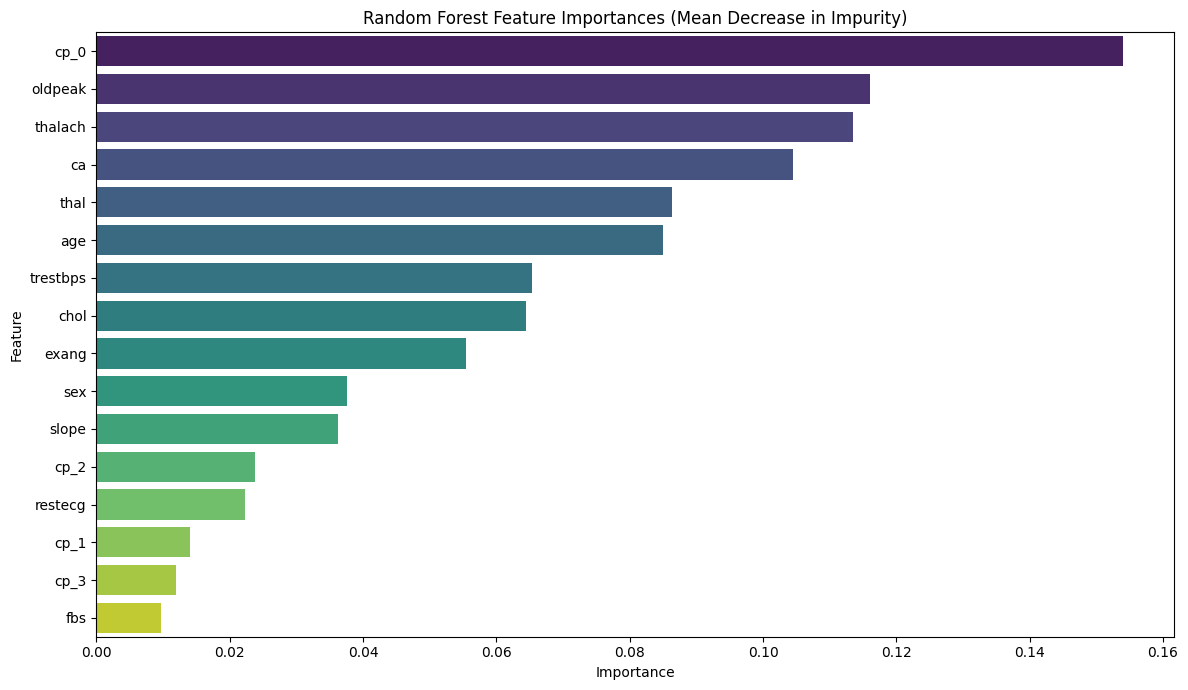

In [9]:
print("\n--- Model-based Feature Importance (Random Forest) ---")
if hasattr(rf_model, 'feature_importances_'):
    feature_importances = pd.Series(rf_model.feature_importances_, index=FEATURES).sort_values(ascending=False)
    print(feature_importances)

    plt.figure(figsize=(12, 7))
    sns.barplot(x=feature_importances, y=feature_importances.index, palette='viridis')
    plt.title('Random Forest Feature Importances (Mean Decrease in Impurity)')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print("Feature importances attribute not found for the trained model.")

# --- 6.2. SHAP (SHapley Additive exPlanations) for Feature Importance ---

In [10]:
print("\n--- SHAP (SHapley Additive exPlanations) for Feature Importance ---")
print("Calculating SHAP values (this may take a moment)...")

# Create a SHAP explainer for the Random Forest model
# For tree-based models, shap.TreeExplainer is efficient
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values for the test set
# Using a sample of the test set for faster computation if test set is very large
# For smaller datasets, you can use X_test_scaled directly
sample_size = min(500, X_test_scaled.shape[0]) # Limit to 500 samples or full test set if smaller
shap_values = explainer.shap_values(X_test_scaled.sample(n=sample_size, random_state=42))

# SHAP values for binary classification models typically return two arrays (for class 0 and class 1)
# We are interested in the impact on predicting the positive class (target=1), so we use shap_values[1]
print("Generating SHAP summary plot...")
shap.summary_plot(shap_values[1], X_test_scaled.sample(n=sample_size, random_state=42), feature_names=FEATURES, show=False)
plt.title('SHAP Summary Plot (Impact on Predicting Disease)')
plt.tight_layout()
plt.show()


--- SHAP (SHapley Additive exPlanations) for Feature Importance ---
Calculating SHAP values (this may take a moment)...


NameError: name 'shap' is not defined

In [11]:
print("\nFeature Importance Analysis complete. Plots have been generated.")


Feature Importance Analysis complete. Plots have been generated.
